# Building a House Price Predictor API  
The client is interested in forecasting houses so the company can look to invest. Rather than using a registered valuer they're looking for something which can be done using the latest technology. Jamie has collected some data on existing house prices over the last few years and has asked to see what you can do. 

# 1. Import Data

In [2]:
%pip install pandas scikit-learn xgboost dill

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd

C:\Users\91798\AppData\Local\Temp\ipykernel_16860\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
df=pd.read_csv(r"C:\Users\91798\Downloads\HousePricePredictionStartHere-221231-153244\regressiondata.csv",index_col="ID")

In [5]:
df.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
0,2020.12,17.0,467.644775,4.0,5222.0,467104
1,2021.04,36.0,659.924963,3.0,5222.0,547714
2,2019.04,38.0,305.475941,7.0,5213.0,277232
3,2021.10,11.0,607.034754,5.0,5213.0,295958
4,2021.02,14.0,378.827222,5.0,5614.0,439963


In [6]:
df.tail()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
9351,2019.07,36.0,554.324820,3.0,5217.0,420246
9352,2021.02,21.0,2296.349397,4.0,5614.0,256087
9353,2020.11,18.0,856.174897,0.0,5614.0,257663
9354,2021.10,6.0,87.260667,9.0,5614.0,681072
9355,2020.12,20.0,584.007146,4.0,5614.0,403096


In [7]:
df.iloc[9355]

TransactionDate         2020.12
HouseAge                   20.0
DistanceToStation    584.007146
NumberOfPubs                4.0
PostCode                 5614.0
HousePrice               403096
Name: 9355, dtype: object

# 2. Split Data to Prevent Snooping Bias

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train,test=train_test_split(df,test_size=0.3,random_state=1234)

In [10]:
train.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
8450,2021.02,34.0,460.994365,8.0,5614.0,460286
5758,2020.01,17.0,614.851833,3.0,5213.0,253332
4030,2021.06,34.0,285.892687,9.0,5614.0,486532
8447,2020.12,0.0,195.213314,6.0,5222.0,595168
4370,2019.03,34.0,124.082230,8.0,5212.0,250495


In [11]:
test.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
7857,2021.11,0.0,267.000535,6.0,5222.0,919497
1641,2021.04,12.0,500.080510,5.0,5212.0,283680
3620,2019.07,14.0,4024.663391,0.0,5614.0,135818
2820,2020.09,18.0,568.954185,4.0,5614.0,468742
1572,2020.07,11.0,44.210016,1.0,5614.0,311065


# 3. Exploratory Data Analysis

## Bird's Eye View

In [12]:
train.dtypes

TransactionDate      float64
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode             float64
HousePrice            object
dtype: object

In [13]:
train.iloc[0]['HousePrice']

'460286'

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6549 entries, 8450 to 8915
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TransactionDate    6548 non-null   float64
 1   HouseAge           6546 non-null   float64
 2   DistanceToStation  6547 non-null   float64
 3   NumberOfPubs       6547 non-null   float64
 4   PostCode           6547 non-null   float64
 5   HousePrice         6544 non-null   object 
dtypes: float64(5), object(1)
memory usage: 358.1+ KB


In [15]:
train.describe()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode
count,6548.000000,6546.000000,6547.000000,6.547000e+03,6547.000000
mean,2020.072389,17.375344,1091.759504,7.677828e+02,5294.499160
std,0.815922,11.469272,1270.038426,6.179430e+04,158.397718
min,2019.010000,0.000000,23.829424,0.000000e+00,5212.000000
25%,2019.100000,9.000000,268.649033,1.000000e+00,5213.000000
50%,2020.070000,15.000000,545.312168,4.000000e+00,5217.000000
75%,2021.040000,28.000000,1529.343484,6.000000e+00,5222.000000
max,2021.120000,43.000000,6486.256457,4.999999e+06,5614.000000


In [16]:
train['PostCode']=train['PostCode'].astype(str)
train['TransactionDate']=train['TransactionDate'].astype(str)

In [17]:
train[['PostCode']]

,PostCode
ID,
8450,5614.0
5758,5213.0
4030,5614.0
8447,5222.0
4370,5212.0
...,...
664,5217.0
7540,5212.0
7221,5217.0


In [18]:
train.describe(include='object')

,TransactionDate,PostCode,HousePrice
count,6549,6549,6544
unique,37,6,6496
top,2019.01,5212.0,290262
freq,212,1338,2


## Analyse Numerical Attributes

### Plot Distributions

In [19]:
%pip install matplotlib seaborn 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
%pip show matplotlib

Name: matplotlib
Version: 3.8.2
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: c:\Users\91798\Documents\Full Stack Machine Learning\fullstack\Lib\site-packages
Requires: contourpy, cycler, fonttools, kiwisolver, numpy, packaging, pillow, pyparsing, python-dateutil
Required-by: seaborn
Note: you may need to restart the kernel to use updated packages.


In [21]:
from matplotlib import pyplot as plt 
import seaborn as sns

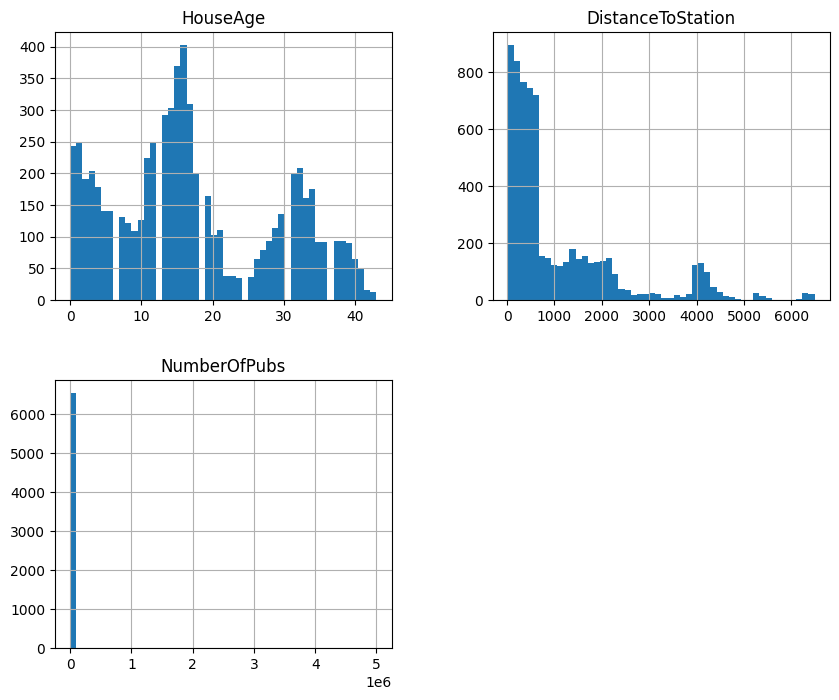

In [22]:
train.hist(figsize=(10,8),bins=50)
plt.show()

### Why isn't House Price Showing up as Numeric?

In [23]:
train['HousePrice']=train['HousePrice'].astype(float)

ValueError: could not convert string to float: '??'

In [24]:
train[train['HousePrice']=='??']

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
8718,2020.08,16.0,122.432508,5.0,5213.0,??


In [25]:
train=train[train['HousePrice']!='??']

In [26]:
train[train['HousePrice']=='??']

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,


In [27]:
train['HousePrice']=train['HousePrice'].astype(float)

In [28]:
train.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice           float64
dtype: object

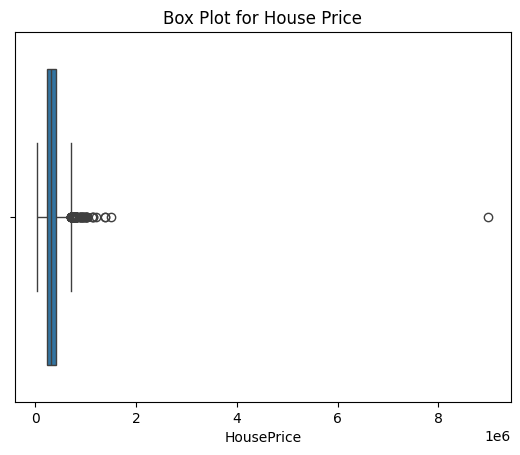

In [29]:
plt.title('Box Plot for House Price')
sns.boxplot(x=train['HousePrice'])
plt.show()

### Drop Outlier 

In [30]:
train.sort_values('HousePrice').tail(10)

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
9238,2019.11,10.0,169.424413,1.0,5222.0,1205920.0
149,2020.09,9.0,228.930655,1.0,5222.0,1374277.0
6066,2020.12,10.0,234.680008,1.0,5222.0,1374386.0
2749,2021.06,9.0,38.864337,1.0,5222.0,1504501.0
8445,2021.05,0.0,276.789752,9.0,5222.0,8989772.0
8103,2019.05,7.0,640.223538,10.0,5217.0,NaN
7673,nan,NaN,3830.892098,0.0,5217.0,NaN
32,2021.1,29.0,809.864711,8.0,5222.0,NaN
8112,2019.08,20.0,370.088151,NaN,nan,NaN


In [31]:
train=train.drop(8445)

In [32]:
train.sort_values('HousePrice').tail(10)

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
5091,2020.05,10.0,295.072723,1.0,5614.0,1151940.0
9238,2019.11,10.0,169.424413,1.0,5222.0,1205920.0
149,2020.09,9.0,228.930655,1.0,5222.0,1374277.0
6066,2020.12,10.0,234.680008,1.0,5222.0,1374386.0
2749,2021.06,9.0,38.864337,1.0,5222.0,1504501.0
8103,2019.05,7.0,640.223538,10.0,5217.0,NaN
7673,nan,NaN,3830.892098,0.0,5217.0,NaN
32,2021.1,29.0,809.864711,8.0,5222.0,NaN
8112,2019.08,20.0,370.088151,NaN,nan,NaN


### What's happening with pubs

In [33]:
train.sort_values('NumberOfPubs').tail()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
422,2019.1,32.0,164.514773,10.0,5614.0,346126.0
5763,2020.02,33.0,326.339631,10.0,5222.0,555253.0
13,2019.05,8.0,273.264542,4999999.0,5213.0,356012.0
2416,2019.06,NaN,NaN,NaN,5222.0,268172.0
8112,2019.08,20.0,370.088151,NaN,nan,NaN


In [34]:
train.drop(13,inplace=True)

In [35]:
train.sort_values('NumberOfPubs').tail()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
3195,2020.11,32.0,324.371247,10.0,5614.0,488918.0
2996,2020.03,28.0,772.777219,10.0,5217.0,299235.0
5763,2020.02,33.0,326.339631,10.0,5222.0,555253.0
2416,2019.06,NaN,NaN,NaN,5222.0,268172.0
8112,2019.08,20.0,370.088151,NaN,nan,NaN


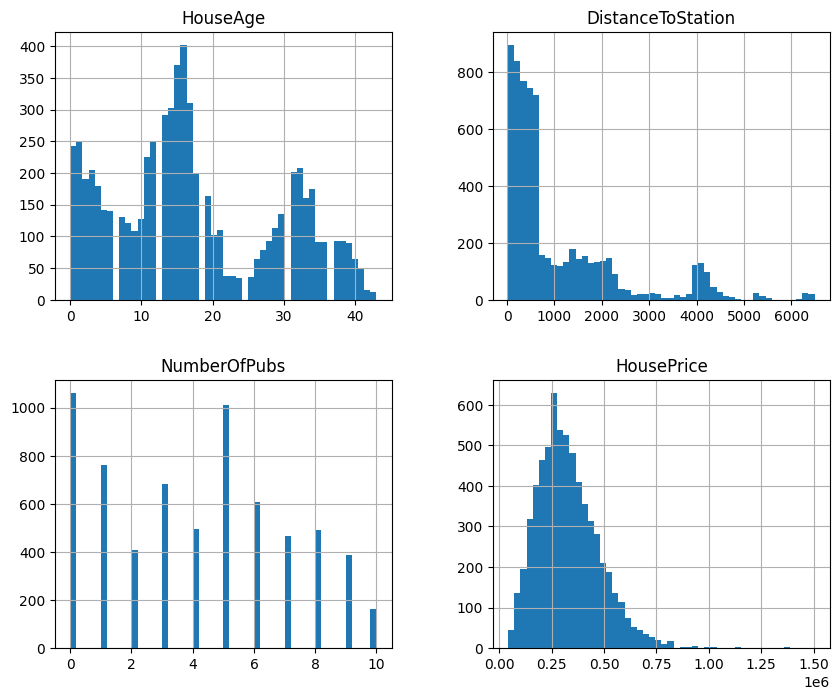

In [36]:
train.hist(figsize=(10,8),bins=50)
plt.show()

## Analyse Categorical Variables

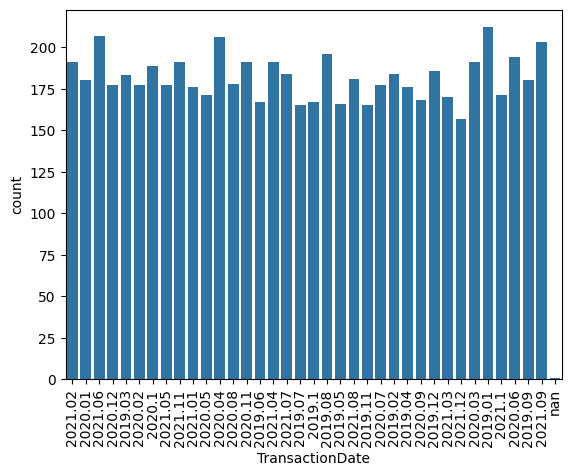

In [37]:
plt.xticks(rotation=90)
sns.countplot(x=train['TransactionDate'])
plt.show()

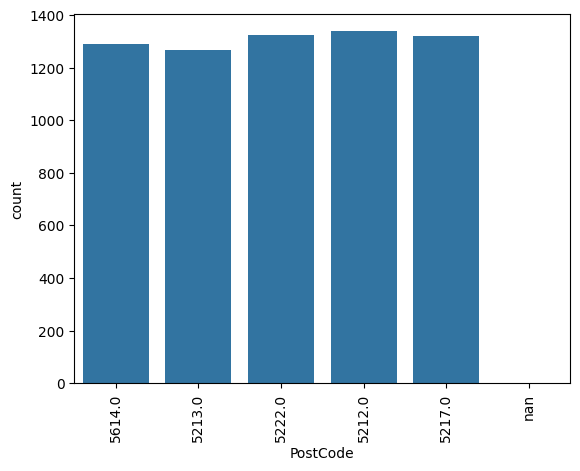

In [38]:
plt.xticks(rotation=90)
sns.countplot(x=train['PostCode'])
plt.show()

## Analyse Relationships Numeric/Numeric

### Calculate Pearson's Correlation

In [39]:
train.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice           float64
dtype: object

In [40]:
train.select_dtypes(exclude='object').corr()

,HouseAge,DistanceToStation,NumberOfPubs,HousePrice
HouseAge,1.000000,0.034074,0.044189,-0.156693
DistanceToStation,0.034074,1.000000,-0.586704,-0.539859
NumberOfPubs,0.044189,-0.586704,1.000000,0.452309
HousePrice,-0.156693,-0.539859,0.452309,1.000000


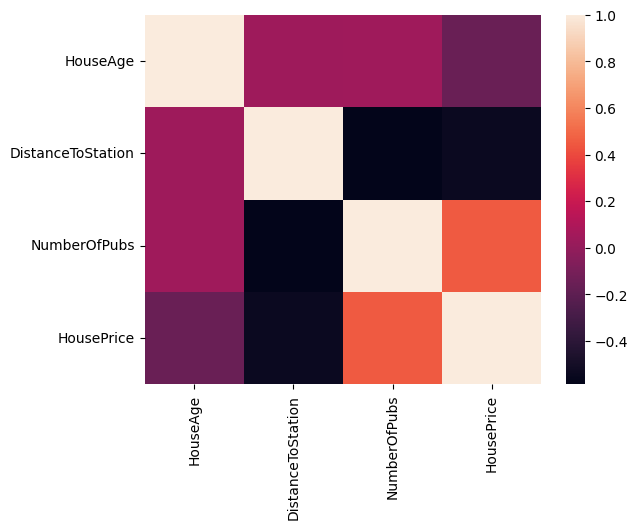

In [41]:
sns.heatmap(train.select_dtypes(exclude='object').corr())
plt.show()

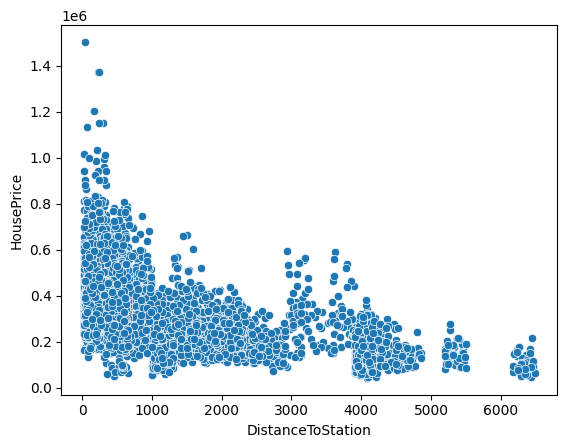

In [42]:
sns.scatterplot(x='DistanceToStation',y='HousePrice',data=train)
plt.show()

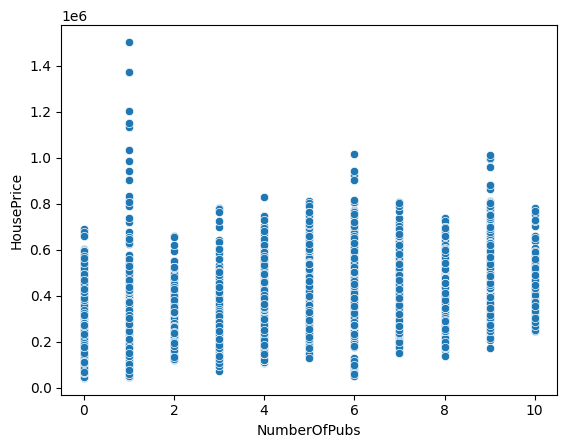

In [43]:
sns.scatterplot(x='NumberOfPubs',y='HousePrice',data=train)
plt.show()

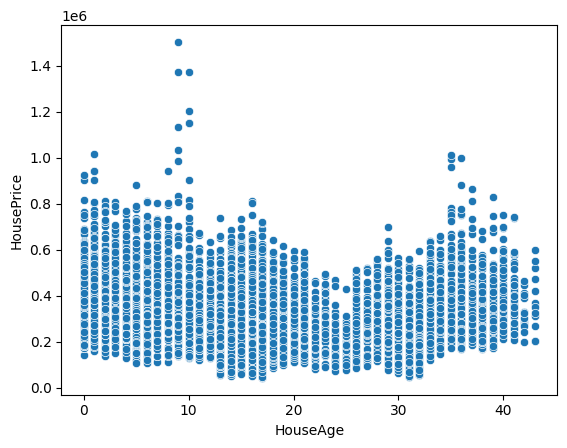

In [44]:
sns.scatterplot(x='HouseAge',y='HousePrice',data=train)
plt.show()

## Analyse Relationships Cat/Num

### Is Post Code Driving Value?

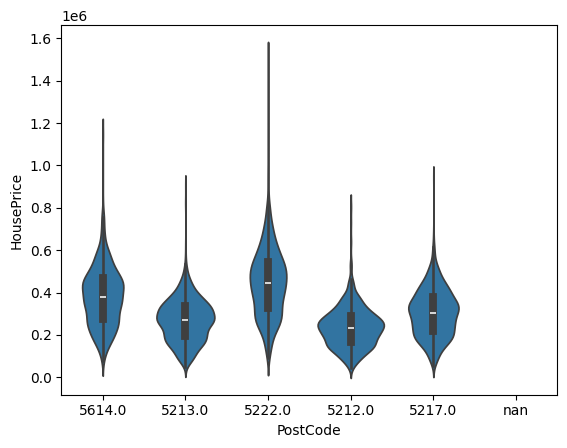

In [45]:
sns.violinplot(x='PostCode',y='HousePrice',data=train)
plt.show()

### What about the date it was sold?

In [46]:
train[train['TransactionDate'].isnull()]

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,


In [47]:
train[train['TransactionDate']=='nan']

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
7673,nan,NaN,3830.892098,0.0,5217.0,NaN


In [48]:
train=train[~train['HousePrice'].isnull()]

In [49]:
train[train['TransactionDate']=='nan']

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,


In [50]:
int(train.iloc[0]['TransactionDate'][:4])

2021

In [51]:
int(train.iloc[0]['TransactionDate'][5:])

2

In [52]:
train['YearSold']=train['TransactionDate'].apply(lambda x: x[:4]).astype(int)
train['MonthSold']=train['TransactionDate'].apply(lambda x: x[5:]).astype(int)

In [53]:
train.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice,YearSold,MonthSold
ID,,,,,,,,
8450,2021.02,34.0,460.994365,8.0,5614.0,460286.0,2021,2
5758,2020.01,17.0,614.851833,3.0,5213.0,253332.0,2020,1
4030,2021.06,34.0,285.892687,9.0,5614.0,486532.0,2021,6
8447,2020.12,0.0,195.213314,6.0,5222.0,595168.0,2020,12
4370,2019.03,34.0,124.082230,8.0,5212.0,250495.0,2019,3


In [54]:
train.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice           float64
YearSold               int32
MonthSold              int32
dtype: object

[]

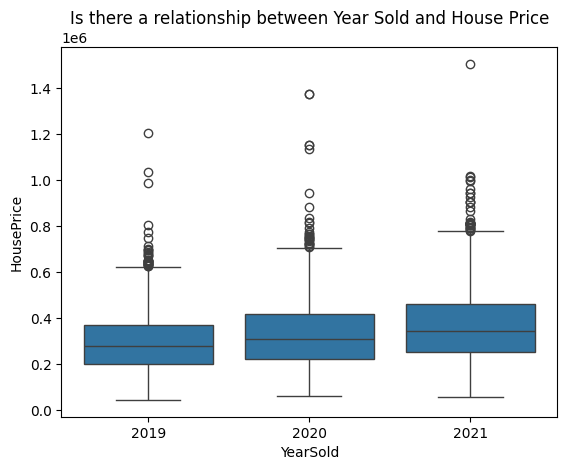

In [55]:
plt.title('Is there a relationship between Year Sold and House Price')
sns.boxplot(x='YearSold',y='HousePrice',data=train)
plt.plot()

[]

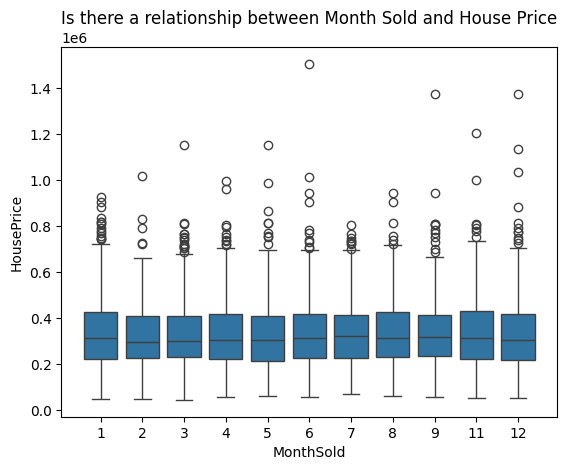

In [56]:
plt.title('Is there a relationship between Month Sold and House Price')
sns.boxplot(x='MonthSold',y='HousePrice',data=train)
plt.plot()

# 4. Data Preprocessing

## Build Preprocessing Function

In [57]:
#StandardScaler makes it of unit variance, OneHotEncoder creates columns with 1's&0's against the categories
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
#here the missing values are replaced 
from sklearn.impute import SimpleImputer
#these classes are necessary when fit and transform
from sklearn.base import BaseEstimator, TransformerMixin

In [58]:
imputer=SimpleImputer()
imputer.fit(train[['HouseAge','DistanceToStation','NumberOfPubs']])# in fit stage the avaerage value is calculated 

SimpleImputer()

In [59]:
imputer.transform(train[['HouseAge','DistanceToStation','NumberOfPubs']]) #here the above is applied 

array([[3.40000000e+01, 4.60994365e+02, 8.00000000e+00],
       [1.70000000e+01, 6.14851833e+02, 3.00000000e+00],
       [3.40000000e+01, 2.85892687e+02, 9.00000000e+00],
       ...,
       [1.60000000e+01, 6.05834036e+02, 2.00000000e+00],
       [3.60000000e+01, 3.45823461e+01, 7.00000000e+00],
       [1.20000000e+01, 1.59998338e+03, 1.00000000e+00]])

In [60]:
train[train['HouseAge'].isnull()][['HouseAge','DistanceToStation','NumberOfPubs']]

,HouseAge,DistanceToStation,NumberOfPubs
ID,,,
2416,NaN,NaN,NaN
24,NaN,NaN,4.0


In [61]:
imputer.transform(train[train['HouseAge'].isnull()][['HouseAge','DistanceToStation','NumberOfPubs']])

array([[  17.37972167, 1091.84711209,    4.0735474 ],
       [  17.37972167, 1091.84711209,    4.        ]])

In [62]:
train['HouseAge'].mean()

17.379721669980118

In [63]:
train['HouseAge'].std()

11.471006657798647

In [64]:
(34-train['HouseAge'].mean())/train['HouseAge'].std() #Standardisation- spread is 1- evenly distributed with mean 0

1.4488944890220656

In [65]:
(16-train['HouseAge'].mean())/train['HouseAge'].std()

-0.12027904011738184

In [66]:
train['HouseAge']

ID
8450    34.0
5758    17.0
4030    34.0
8447     0.0
4370    34.0
        ... 
664     37.0
7540    34.0
7221    16.0
1318    36.0
8915    12.0
Name: HouseAge, Length: 6541, dtype: float64

In [67]:
onehot=OneHotEncoder()
onehot.fit(train[['PostCode']]) # in this step it finds out the categories

OneHotEncoder()

In [68]:
onehot.transform(train[['PostCode']]).toarray() # the new columns with the values against them are obtained 

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [69]:
onehot.get_feature_names_out()

array(['PostCode_5212.0', 'PostCode_5213.0', 'PostCode_5217.0',
       'PostCode_5222.0', 'PostCode_5614.0'], dtype=object)

In [70]:
train['PostCode']

ID
8450    5614.0
5758    5213.0
4030    5614.0
8447    5222.0
4370    5212.0
         ...  
664     5217.0
7540    5212.0
7221    5217.0
1318    5217.0
8915    5614.0
Name: PostCode, Length: 6541, dtype: object

In [111]:
class Preprocessor(BaseEstimator, TransformerMixin):
    #Train our custom preprocessors
    def fit(self,X,y=None):
        #Create and fit simple imputer
        self.imputer=SimpleImputer()
        self.imputer.fit(X[['HouseAge','DistanceToStation','NumberOfPubs']])

        #Create and fit standard scaler
        self.scaler=StandardScaler()
        self.scaler.fit(X[['HouseAge','DistanceToStation','NumberOfPubs']])

        #Create and fit onehot encoder - ignore is so that if new unknown category comes up all the values will be 0
        self.onehot=OneHotEncoder(handle_unknown='ignore')
        self.onehot.fit(X[['PostCode']])
        return self

    #Apply our custom preprocessors
    def transform(self,X):

        #Apply simple imputer
        imputed_cols=self.imputer.transform(X[['HouseAge','DistanceToStation','NumberOfPubs']]) 
        onehot_cols=self.onehot.transform(X[['PostCode']])
        
        #Create the df
        transformed_df=X.copy()

        #Apply year and month transforms
        transformed_df['Year']=transformed_df['TransactionDate'].apply(lambda x: x[:4]).astype(int)
        transformed_df['Month']=transformed_df['TransactionDate'].apply(lambda x: x[5:]).astype(int)
        transformed_df=transformed_df.drop('TransactionDate',axis=1)
        
        #Apply the transformed columns 
        transformed_df[['HouseAge','DistanceToStation','NumberOfPubs']]=imputed_cols
        transformed_df[['HouseAge','DistanceToStation','NumberOfPubs']]=self.scaler.transform(transformed_df[['HouseAge','DistanceToStation','NumberOfPubs']])

        #Drop existing postcode column and replace with one hot equivalent
        transformed_df=transformed_df.drop('PostCode',axis=1)
        transformed_df[self.onehot.get_feature_names_out()]=onehot_cols.toarray().astype(int)

        return transformed_df

In [112]:
preproc=Preprocessor()

In [113]:
preproc.fit(train)

Preprocessor()

## Preview Preprocessed Data

In [117]:
preprocessed_df=preproc.transform(train)
preprocessed_df.head()

,HouseAge,DistanceToStation,NumberOfPubs,HousePrice,Year,Month,PostCode_5212.0,PostCode_5213.0,PostCode_5217.0,PostCode_5222.0,PostCode_5614.0
ID,,,,,,,,,,,
8450,1.449005,-0.496716,1.328375,460286.0,2021,2,0,0,0,0,1
5758,-0.033105,-0.375573,-0.363196,253332.0,2020,1,0,1,0,0,0
4030,1.449005,-0.634586,1.666689,486532.0,2021,6,0,0,0,0,1
8447,-1.515216,-0.705984,0.651746,595168.0,2020,12,0,0,0,1,0
4370,1.449005,-0.761991,1.328375,250495.0,2019,3,1,0,0,0,0


In [115]:
preprocessed_df.dtypes

HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
HousePrice           float64
Year                   int32
Month                  int32
PostCode_5212.0        int32
PostCode_5213.0        int32
PostCode_5217.0        int32
PostCode_5222.0        int32
PostCode_5614.0        int32
dtype: object

In [78]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6541 entries, 8450 to 8915
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HouseAge           6541 non-null   float64
 1   DistanceToStation  6541 non-null   float64
 2   NumberOfPubs       6541 non-null   float64
 3   HousePrice         6541 non-null   float64
 4   Year               6541 non-null   int32  
 5   Month              6541 non-null   int32  
 6   PostCode_5212.0    6541 non-null   int32  
 7   PostCode_5213.0    6541 non-null   int32  
 8   PostCode_5217.0    6541 non-null   int32  
 9   PostCode_5222.0    6541 non-null   int32  
 10  PostCode_5614.0    6541 non-null   int32  
dtypes: float64(4), int32(7)
memory usage: 434.4 KB


## Clean up Analysis Features

In [80]:
train=train.drop(['YearSold','MonthSold'],axis=1)

In [81]:
train.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
8450,2021.02,34.0,460.994365,8.0,5614.0,460286.0
5758,2020.01,17.0,614.851833,3.0,5213.0,253332.0
4030,2021.06,34.0,285.892687,9.0,5614.0,486532.0
8447,2020.12,0.0,195.213314,6.0,5222.0,595168.0
4370,2019.03,34.0,124.082230,8.0,5212.0,250495.0


## Create X and y values

In [82]:
X_train=train.drop('HousePrice',axis=1)
y_train=train['HousePrice']

# 5. Modelling

## Import ML Dependencies

In [83]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor

## Create Pipelines

In [118]:
pipelines={
    'ridge':make_pipeline(Preprocessor(),Ridge()),
    'rf':make_pipeline(Preprocessor(),RandomForestRegressor()),
    'gb':make_pipeline(Preprocessor(),GradientBoostingRegressor()),
    'xg':make_pipeline(Preprocessor(),XGBRegressor())
}

In [119]:
pipelines['ridge']

Pipeline(steps=[('preprocessor', Preprocessor()), ('ridge', Ridge())])

## Create Tuning Grids

In [120]:
pipelines['ridge'].named_steps

{'preprocessor': Preprocessor(), 'ridge': Ridge()}

In [121]:
pipelines['ridge'].get_params()

{'memory': None,
 'steps': [('preprocessor', Preprocessor()), ('ridge', Ridge())],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'ridge': Ridge(),
 'ridge__alpha': 1.0,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__positive': False,
 'ridge__random_state': None,
 'ridge__solver': 'auto',
 'ridge__tol': 0.0001}

In [122]:
pipelines['ridge']['ridge'].alpha

1.0

In [123]:
pipelines['rf'].get_params()

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('randomforestregressor', RandomForestRegressor())],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'randomforestregressor': RandomForestRegressor(),
 'randomforestregressor__bootstrap': True,
 'randomforestregressor__ccp_alpha': 0.0,
 'randomforestregressor__criterion': 'squared_error',
 'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 1.0,
 'randomforestregressor__max_leaf_nodes': None,
 'randomforestregressor__max_samples': None,
 'randomforestregressor__min_impurity_decrease': 0.0,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__min_weight_fraction_leaf': 0.0,
 'randomforestregressor__monotonic_cst': None,
 'randomforestregressor__n_estimators': 100,
 'randomforestregressor__n_jobs': None,
 'randomforestregressor__oob_score': False,
 'randomforestregressor__random_state': None,
 'randomforestregressor__verbose

In [124]:
pipelines['gb'].get_params()

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('gradientboostingregressor', GradientBoostingRegressor())],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'gradientboostingregressor': GradientBoostingRegressor(),
 'gradientboostingregressor__alpha': 0.9,
 'gradientboostingregressor__ccp_alpha': 0.0,
 'gradientboostingregressor__criterion': 'friedman_mse',
 'gradientboostingregressor__init': None,
 'gradientboostingregressor__learning_rate': 0.1,
 'gradientboostingregressor__loss': 'squared_error',
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__max_features': None,
 'gradientboostingregressor__max_leaf_nodes': None,
 'gradientboostingregressor__min_impurity_decrease': 0.0,
 'gradientboostingregressor__min_samples_leaf': 1,
 'gradientboostingregressor__min_samples_split': 2,
 'gradientboostingregressor__min_weight_fraction_leaf': 0.0,
 'gradientboostingregressor__n_estimators': 100,
 'gradientboostingregressor__n_iter_no_change': None,
 'g

In [125]:
pipelines['xg'].get_params()

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('xgbregressor',
   XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, random_state=None, ...))],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'xgbregressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
       

In [128]:
grid={
    'ridge':{'ridge__alpha':[0.05,0.25,0.5,1.0]},
    'rf':{
        'randomforestregressor__n_estimators':[100,200,300],
        'randomforestregressor__max_depth':[5,6,7,None]
    },
    'gb':{
        'gradientboostingregressor__n_estimators':[100,200,300],
        'gradientboostingregressor__max_depth':[5,6,7,None]
    },
    'xg':{
        'xgbregressor__n_estimators':[100,200,300],
        'xgbregressor__max_depth':[5,6,7,None]
    }
}

## Train Models and Perform HPO

In [95]:
from sklearn.model_selection import GridSearchCV

In [129]:
fit_models={}

for algo,pipeline in pipelines.items():
    try:
        print(algo)
        model=GridSearchCV(pipeline,grid[algo],n_jobs=-1,cv=10,scoring='r2',error_score='raise')
        model.fit(X_train,y_train)
        fit_models[algo]=model
    except Exception as e:
        print(f'Model {algo} had an error {e}')


ridge
rf
gb
xg


In [130]:
fit_models

{'ridge': GridSearchCV(cv=10, error_score='raise',
              estimator=Pipeline(steps=[('preprocessor', Preprocessor()),
                                        ('ridge', Ridge())]),
              n_jobs=-1, param_grid={'ridge__alpha': [0.05, 0.25, 0.5, 1.0]},
              scoring='r2'),
 'rf': GridSearchCV(cv=10, error_score='raise',
              estimator=Pipeline(steps=[('preprocessor', Preprocessor()),
                                        ('randomforestregressor',
                                         RandomForestRegressor())]),
              n_jobs=-1,
              param_grid={'randomforestregressor__max_depth': [5, 6, 7, None],
                          'randomforestregressor__n_estimators': [100, 200,
                                                                  300]},
              scoring='r2'),
 'gb': GridSearchCV(cv=10, error_score='raise',
              estimator=Pipeline(steps=[('preprocessor', Preprocessor()),
                                        ('gra

# 6. Evaluate Models

## Import Evaluation Metrics

In [131]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Preprocess Test Set For Predictions

### Look for Nulls

In [133]:
test.isnull().sum()

TransactionDate      1
HouseAge             1
DistanceToStation    0
NumberOfPubs         0
PostCode             0
HousePrice           2
dtype: int64

In [139]:
test=test[~test['HousePrice'].isnull()]

In [141]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2805 entries, 7857 to 641
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TransactionDate    2805 non-null   float64
 1   HouseAge           2804 non-null   float64
 2   DistanceToStation  2805 non-null   float64
 3   NumberOfPubs       2805 non-null   float64
 4   PostCode           2805 non-null   float64
 5   HousePrice         2805 non-null   object 
dtypes: float64(5), object(1)
memory usage: 153.4+ KB


### Check datatypes

In [142]:
test.dtypes

TransactionDate      float64
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode             float64
HousePrice            object
dtype: object

In [143]:
test=test[test['HousePrice']!='??']
test['HousePrice']=test['HousePrice'].astype(float)
test['TransactionDate']=test['TransactionDate'].astype(str)
test['PostCode']=test['PostCode'].astype(str)

C:\Users\91798\AppData\Local\Temp\ipykernel_16860\2101535220.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['HousePrice']=test['HousePrice'].astype(float)
C:\Users\91798\AppData\Local\Temp\ipykernel_16860\2101535220.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['TransactionDate']=test['TransactionDate'].astype(str)
C:\Users\91798\AppData\Local\Temp\ipykernel_16860\2101535220.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [144]:
test.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice           float64
dtype: object

### Create X_test and y_test 

In [145]:
X_test=test.drop('HousePrice',axis=1)
y_test=test['HousePrice']

In [147]:
X_test.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode
ID,,,,,
7857,2021.11,0.0,267.000535,6.0,5222.0
1641,2021.04,12.0,500.080510,5.0,5212.0
3620,2019.07,14.0,4024.663391,0.0,5614.0
2820,2020.09,18.0,568.954185,4.0,5614.0
1572,2020.07,11.0,44.210016,1.0,5614.0


In [149]:
X_test.shape

(2803, 5)

In [150]:
y_test.shape

(2803,)

## Calculate Regression Metrics

In [152]:
for algo, model in fit_models.items():
    yhat=model.predict(X_test)
    r2=r2_score(y_test,yhat)
    mae=mean_absolute_error(y_test,yhat)
    print(f'{algo}-R2 Score:{r2}, MAE Score:{mae}')


ridge-R2 Score:0.6691443155811748, MAE Score:62578.08779739753
rf-R2 Score:0.820131730310151, MAE Score:44654.59334641455
gb-R2 Score:0.8630231901840698, MAE Score:38704.16093597917
xg-R2 Score:0.856389713877994, MAE Score:39308.03106325812


## Make Predictions

In [153]:
model=fit_models['gb']

In [154]:
yhat=model.predict(X_test)

In [157]:
results_df=y_test.to_frame()
results_df['yhat']=yhat
results_df['delta']=results_df['HousePrice']-results_df.yhat

In [158]:
results_df

,HousePrice,yhat,delta
ID,,,
7857,919497.0,660072.297268,259424.702732
1641,283680.0,289177.792976,-5497.792976
3620,135818.0,166619.494653,-30801.494653
2820,468742.0,398384.284510,70357.715490
1572,311065.0,389518.489960,-78453.489960
...,...,...,...
435,234950.0,312868.879993,-77918.879993
3452,467844.0,464408.266592,3435.733408
2127,502553.0,392935.059367,109617.940633


In [159]:
results_df.to_csv

<bound method NDFrame.to_csv of       HousePrice           yhat          delta
ID                                            
7857    919497.0  660072.297268  259424.702732
1641    283680.0  289177.792976   -5497.792976
3620    135818.0  166619.494653  -30801.494653
2820    468742.0  398384.284510   70357.715490
1572    311065.0  389518.489960  -78453.489960
...          ...            ...            ...
435     234950.0  312868.879993  -77918.879993
3452    467844.0  464408.266592    3435.733408
2127    502553.0  392935.059367  109617.940633
7510    766626.0  737461.996758   29164.003242
641     437310.0  411115.310178   26194.689822

[2803 rows x 3 columns]>

## Explain model

### Calculate Feature Importance

In [167]:
model.best_estimator_['gradientboostingregressor']

GradientBoostingRegressor(max_depth=5, n_estimators=300)

In [168]:
model.best_estimator_['gradientboostingregressor'].feature_importances_

array([0.12752548, 0.46765551, 0.04501102, 0.05171466, 0.00633476,
       0.02392426, 0.00642725, 0.00965766, 0.17487863, 0.08687076])

In [169]:
ensemble=model.best_estimator_['gradientboostingregressor']

<BarContainer object of 10 artists>

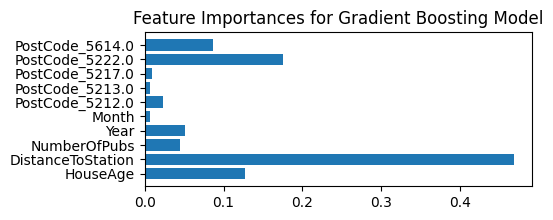

In [173]:
plt.figure(figsize=(5,2))
plt.title('Feature Importances for Gradient Boosting Model')
plt.barh(ensemble.feature_names_in_,ensemble.feature_importances_)

### Calculate Feature Importance for All Models

In [174]:
import numpy as np 


In [176]:
feature_importances={}
for algo,pipeline in fit_models.items():
    if algo=='ridge':
        coef_=pipeline.best_estimator_[1].coef_
        feature_importances[algo]=np.square(coef_)/np.sum(np.square(coef_))
    else:
        feature_importances[algo]=pipeline.best_estimator_[1].feature_importances_


In [177]:
importance_df=pd.DataFrame(feature_importances,index=ensemble.feature_names_in_)
importance_df

,ridge,rf,gb,xg
HouseAge,0.016484,0.136451,0.127525,0.036302
DistanceToStation,0.101874,0.443994,0.467656,0.099505
NumberOfPubs,0.031097,0.055923,0.045011,0.020199
Year,0.038686,0.051278,0.051715,0.063811
Month,0.000006,0.034806,0.006335,0.005484
PostCode_5212.0,0.225705,0.008691,0.023924,0.071544
PostCode_5213.0,0.094727,0.002823,0.006427,0.011128
PostCode_5217.0,0.016941,0.012059,0.009658,0.076408
PostCode_5222.0,0.392286,0.167438,0.174879,0.381033
PostCode_5614.0,0.082193,0.086537,0.086871,0.234587


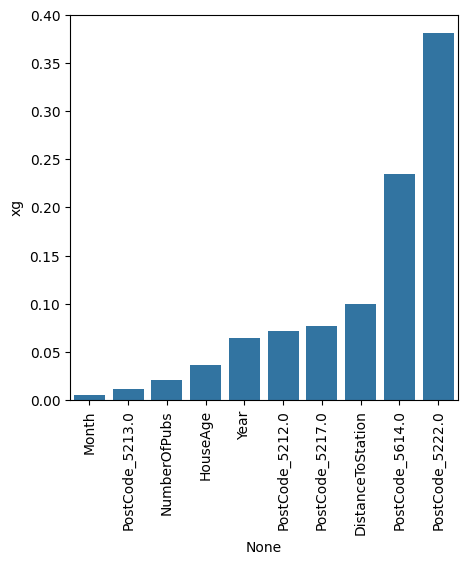

In [178]:
plt.figure(figsize=(5,5))
model_name='xg'
sorted_imp=importance_df.sort_values(model_name)
sns.barplot(x=sorted_imp.index,y=model_name,data=sorted_imp)
plt.xticks(rotation=90)
plt.show()

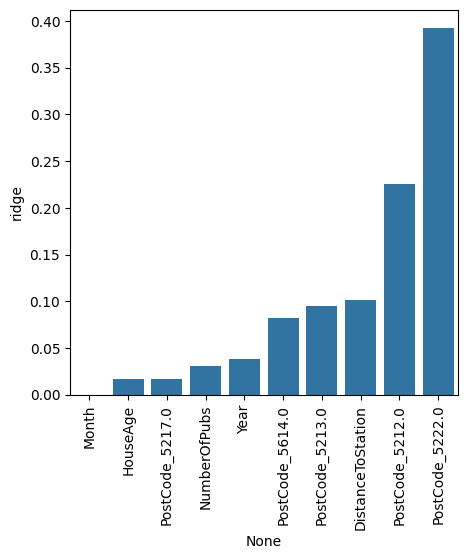

In [179]:
plt.figure(figsize=(5,5))
model_name='ridge'
sorted_imp=importance_df.sort_values(model_name)
sns.barplot(x=sorted_imp.index,y=model_name,data=sorted_imp)
plt.xticks(rotation=90)
plt.show()

### Plot Trees

In [188]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [181]:
from sklearn.tree import plot_tree
#import xgboost as xgb 
#from matplotlib.pylab import rcParams

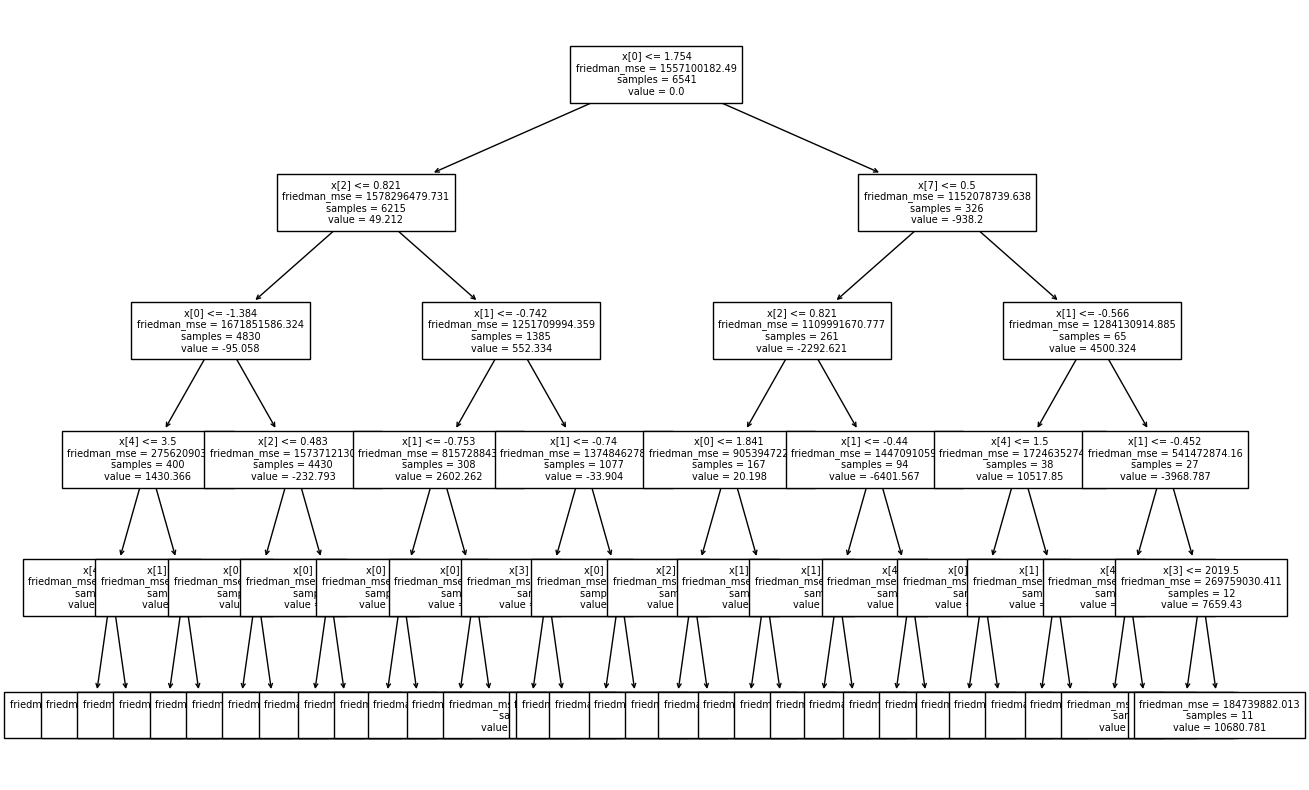

In [184]:
plt.figure(figsize=(15,10))
plot_tree(ensemble.estimators_[299,0],fontsize=7)
plt.show()

In [185]:
ensemble.feature_names_in_

array(['HouseAge', 'DistanceToStation', 'NumberOfPubs', 'Year', 'Month',
       'PostCode_5212.0', 'PostCode_5213.0', 'PostCode_5217.0',
       'PostCode_5222.0', 'PostCode_5614.0'], dtype=object)

In [192]:
#rcParams['figure.figsize']=100,100
#xgb.plot_tree(fit_models['xg'].best_estimator_[1])
#plt.show()

# 7. Save model

In [193]:
import dill

In [194]:
model=fit_models['gb']

In [195]:
with open('gb.pkl','wb') as f:
    dill.dump(model,f)

In [196]:
with open('gb.pkl','rb') as f:
    reloaded_model=dill.load(f)

In [197]:
reloaded_model

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor', Preprocessor()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'gradientboostingregressor__max_depth': [5, 6, 7,
                                                                  None],
                         'gradientboostingregressor__n_estimators': [100, 200,
                                                                     300]},
             scoring='r2')

In [201]:
X_test.loc[0].to_json()

'{"TransactionDate":"2020.12","HouseAge":17.0,"DistanceToStation":467.6447748,"NumberOfPubs":4.0,"PostCode":"5222.0"}'